In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K




In [2]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [3]:
## trainer 

"""
 Sample script using EEGNet to classify Event-Related Potential (ERP) EEG data
 from a four-class classification task, using the sample dataset provided in
 the MNE [1, 2] package:
     https://martinos.org/mne/stable/manual/sample_dataset.html#ch-sample-data
   
 The four classes used from this dataset are:
     LA: Left-ear auditory stimulation
     RA: Right-ear auditory stimulation
     LV: Left visual field stimulation
     RV: Right visual field stimulation

 The code to process, filter and epoch the data are originally from Alexandre
 Barachant's PyRiemann [3] package, released under the BSD 3-clause. A copy of 
 the BSD 3-clause license has been provided together with this software to 
 comply with software licensing requirements. 
 
 When you first run this script, MNE will download the dataset and prompt you
 to confirm the download location (defaults to ~/mne_data). Follow the prompts
 to continue. The dataset size is approx. 1.5GB download. 
 
"""

import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
# from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################
data_path = sample.data_path()

# Set parameters and read data
raw_fname = str(data_path) + '\MEG\sample\sample_audvis_filt-0-40_raw.fif'
event_fname = str(data_path) + '\MEG\sample\sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
labels = epochs.events[:, -1]

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

kernels, chans, samples = 1, 60, 151

# take 50/25/25 percent of the data to train/validate/test
X_train      = X[0:144,]
Y_train      = y[0:144]
X_validate   = X[144:216,]
Y_validate   = y[144:216]
X_test       = X[216:,]
Y_test       = y[216:]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train-1)
Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_validate.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')



Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB

X_train shape: (144, 60, 151, 1)
144 train samples
72 validate samples
72 test samples


In [4]:
X_train[0].shape

(60, 151, 1)

In [5]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples, dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')

model.summary()

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='checkpoint1.h5', verbose=1,
                               save_best_only=True)

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)






Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 151, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 60, 151, 8)        256       
                                                                 
 batch_normalization (Batch  (None, 60, 151, 8)        32        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 151, 16)        960       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 1, 151, 16)        64        
 chNormalization)                                                
                                                             

c:\Users\sandr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.38620 to 1.38617, saving model to checkpoint1.h5
9/9 - 0s - loss: 1.3868 - accuracy: 0.2222 - val_loss: 1.3862 - val_accuracy: 0.2639 - 305ms/epoch - 34ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38617
9/9 - 0s - loss: 1.3692 - accuracy: 0.2917 - val_loss: 1.3862 - val_accuracy: 0.2639 - 279ms/epoch - 31ms/step
Epoch 4/300

Epoch 4: val_loss improved from 1.38617 to 1.38614, saving model to checkpoint1.h5
9/9 - 0s - loss: 1.3596 - accuracy: 0.3333 - val_loss: 1.3861 - val_accuracy: 0.2639 - 372ms/epoch - 41ms/step
Epoch 5/300

Epoch 5: val_loss improved from 1.38614 to 1.38609, saving model to checkpoint1.h5
9/9 - 0s - loss: 1.3591 - accuracy: 0.3889 - val_loss: 1.3861 - val_accuracy: 0.2639 - 335ms/epoch - 37ms/step
Epoch 6/300

Epoch 6: val_loss improved from 1.38609 to 1.38604, saving model to checkpoint1.h5
9/9 - 0s - loss: 1.3445 - accuracy: 0.4028 - val_loss: 1.3860 - val_accuracy: 0.2639 - 319ms/epoch - 35ms/step
Epoch 7/300



In [6]:
X_test[0].shape

(60, 151, 1)

In [7]:
X_test.shape

(72, 60, 151, 1)

In [8]:
# load optimal weights
model.load_weights('checkpoint1.h5')


probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

3/3 [==============================] - 0s 9ms/step
Classification accuracy: 0.861111 


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

 Evaluation:
Accuracy: 0.86
Precision: 0.86
Recall: 0.86




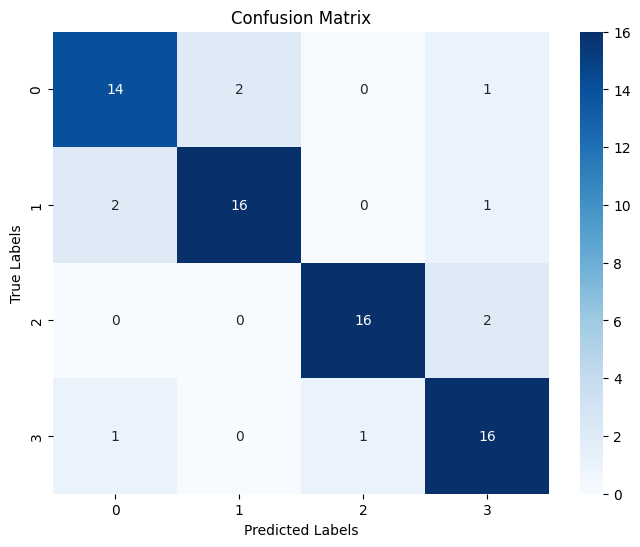

In [10]:
temp = Y_test.argmax(axis=-1)
conf_matrix = confusion_matrix(temp, preds)
accuracy = accuracy_score(temp, preds)
precision = precision_score(temp, preds, average='weighted')
recall = recall_score(temp, preds, average='weighted')

print(f" Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\n")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [11]:
# load optimal weights
model.load_weights('checkpoint1.h5')

In [12]:
model.predict(X_test).argmax(axis = -1)  

3/3 [==============================] - 0s 8ms/step


array([3, 1, 2, 0, 3, 1, 2, 0, 1, 2, 0, 3, 1, 2, 0, 3, 1, 2, 0, 3, 3, 2,
       0, 3, 1, 3, 3, 1, 2, 0, 3, 1, 2, 3, 3, 1, 2, 0, 3, 1, 2, 1, 0, 1,
       2, 0, 3, 0, 3, 1, 2, 0, 3, 1, 2, 0, 3, 1, 2, 1, 2, 1, 2, 0, 3, 0,
       0, 3, 1, 2, 0, 3], dtype=int64)